(custom_response_functions)=
# Using custom response models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/2-Using_custom_response_functions.ipynb)

In [1]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF

plt.rcParams["figure.constrained_layout.use"] = True

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


The probabilistic networks we have been creating so far with the continuous and the binary Hierarchical Gaussian Filter (HGF) are often referred to as {term}`Perceptual model`. This branch of the model acts as a [Bayesian filter](https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation) as it tries to predict the next observation(s) given current and past observations (often noted $u$). In that sense, the HGF is sometimes described as a generalization of Bayesian filters (e.g. a one-level continuous HGF is equivalent to a Kalman filter). Complex probabilistic networks can handle more complex environments for example with nested volatility, with multiple inputs, or with time-varying inputs that dynamically change how beliefs propagate through the structure (see {ref}`probabilistic_networks` for a tutorial on probabilistic networks). 

But no matter how complex those networks are, they are only the *perceptual* side of the model. If we want our agent to be able to act according to the beliefs he/she is having about the environment and evaluate its performances from these actions, we need  what is traditionally called a {term}`Response model` (also sometimes referred to as *decision model* or *observation model*). In a nutshell, a {term}`Response model` describe how we think the agent decide to perform some action at time $t$, and how we can measure the "goodness of fit" of our perceptual model given the observed actions. It critically incorporates a {term}`Decision rule`, which is the function that, given the sufficient statistics of the network's beliefs sample an action from the possible actions at hand.

Being able to write and modify such {term}`Response model` is critical for practical applications of the HGF as it allows users to adapt the models to their specific experimental designs. In this notebook, we will demonstrate how it is possible to write custom response models for a given probabilistic network.

```{figure} ../images/response_models.png
---
name: response-models-fig
---
**The {term}`Perceptual model` and the {term}`Response model` of a Hierarchical Gaussian Filter (HGF)**. The left panel represents the {term}`Perceptual model`. The beliefs that the agent holds on state of the world are updated in the probabilistic network (blue circles) as the agent makes new observations (often noted $u$, e.g. the association between a stimulus and an outcome at time $t$). Using these beliefs, the {term}`Response model` (right panel) selects which decision/action $y$ to perform. Critically here, the {term}`Response model` only operates one-way (i.e. taking beliefs to generate action), but the actions are not modulating the way beliefs are updated (the model does not perform active inference - this point is, however, an active line of researches and new iterations of the model will try to *fusion* the two branch using active inference principles).
```

## Creating a new response function: the binary surprise
To illustrate the creation of new response functions, we are going to use the same binary input vector from the decision task described in {cite:p}`Iglesias2021`.

In [3]:
u, _ = load_data("binary")

For the sake of example here, we will consider that the participant underwent a *one-armed bandit task*, which consisted of the presentations of two stimuli ($S_0$ and $S_1$) that could be associated with two types of outcomes ($O_{+}$ and $O_{-}$). On each trial, the participant was presented with the two stimuli, chose one of them and get an outcome. The underlying contingencies of stimuli associated with positive outcomes are changing over time, in a way that can be more or less volatile. The {term}`Perceptual model` tries to track these contingencies by observing the previous associations. We have already been using this {term}`Perceptual model` model before in the tutorial on the binary HGF ({ref}`binary_hgf`). Here the input data $u$ is the observed association between e.g. $S_0$ and $O_{+}$. In order to incorporate a {term}`Response model` on top of that, we need first to define:
1. a range of possible actions $y$. In this case, the participant has only two alternatives so $y$ can be either `0` or `1`.
2. a {term}`Decision rule` stating how the agent selects between the two actions given the beliefs of the probabilistic network at time $t$. 
In this situation, it is trivial to write such a decision function and generate actions as new inputs are coming in, for simulation purposes for example. We start by setting a {term}`Perceptual model` (i.e. a network of probabilistic nodes updated by observations). Here this is a standard two-level binary HGF, and the inputs are the binary observations (the association between one of the stimuli and the positive reward).

In [4]:
agent = HGF(
    n_levels=2,
    model_type="binary",
    initial_mean={"1": .0, "2": .5},
    initial_precision={"1": .0, "2": 1e4},
    tonic_volatility={"2": -4.0},
).input_data(input_data=u)

This perceptual model has observed the input sequence, meaning that we now have beliefs trajectories for all nodes in the network. The beliefs are stored in the variable `node_trajectories` in the model class, but can also be exported to Pandas using the `to_pandas` method like:

In [5]:
agent.to_pandas().head()

,time_steps,time,x_0_expected_mean,x_0_expected_precision,x_0_mean,x_0_observed,x_0_precision,x_1_expected_mean,x_1_expected_precision,x_1_mean,x_1_observed,x_1_precision,x_0_surprise,x_1_surprise,total_surprise
0,1.0,1.0,0.622459,0.235004,1.0,1,0.235004,0.500000,54.301674,0.506923,1,54.536678,0.474077,-1.077038,-0.602961
1,1.0,2.0,0.624085,0.234603,1.0,1,0.234603,0.506923,27.283697,0.520583,1,27.518301,0.471469,-0.731660,-0.260191
2,1.0,3.0,0.627284,0.233799,1.0,1,0.233799,0.520583,18.296556,0.540697,1,18.530355,0.466356,-0.530717,-0.064361
3,1.0,4.0,0.631975,0.232583,1.0,1,0.232583,0.540697,13.834867,0.566859,1,14.067450,0.458906,-0.389923,0.068983
4,1.0,5.0,0.638038,0.230946,0.0,1,0.230946,0.566859,11.185465,0.510971,1,11.416410,1.016216,-0.270900,0.745316


### Creating the decision rule

The next step is to use these beliefs to generate the corresponding decisions at each time point. We can work on the simplest {term}`Decision rule`, which is probably to use the expected value of the first level a time $t$ to sample from a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) and generate a binary decision. Intuitively, this just means that the agent is more likely to select a given stimulus when the beliefs that is is associated with a positive outcome are close to `1.0`.

In [6]:
# a simple decision rule using the first level of the HGF
np.random.seed(1)
responses = np.random.binomial(p=agent.node_trajectories[0]["expected_mean"], n=1)

This gives us a binary vector of responses $y$ that can be related to observations and underlying beliefs.

Text(0.5, 0, 'Trials')

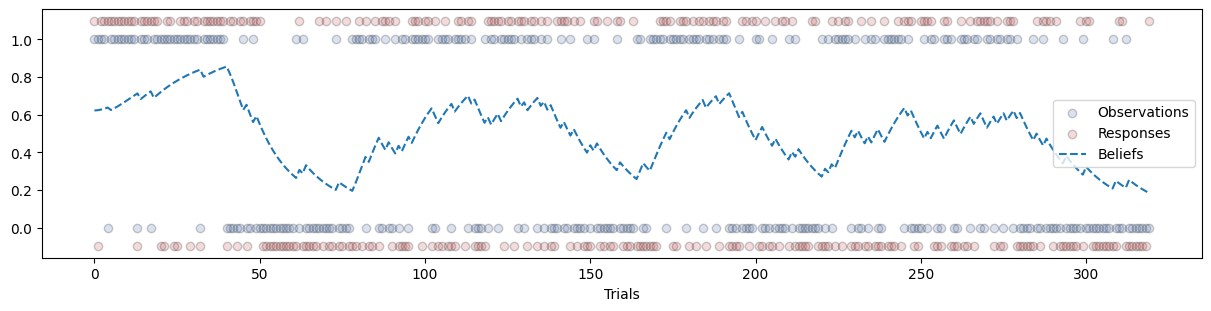

In [7]:
plt.figure(figsize=(12, 3))
jitter = responses * .1 + (1-responses) * -.1
plt.scatter(np.arange(len(u)), u, label="Observations", color="#4c72b0", edgecolor="k", alpha=.2)
plt.scatter(np.arange(len(responses)), responses + jitter, label="Responses", color="#c44e52", alpha=.2, edgecolor="k")
plt.plot(agent.node_trajectories[0]["expected_mean"], label="Beliefs", linestyle="--")
plt.legend()
plt.xlabel("Trials")

We now have the two ingredients required to create a response model:
- the vector `observations` ($u$) that encode the current association between the stimuli and the outcomes.
- the vector `responses` ($y$) that encode the inferred association by the participant, using the expected value at time $t$ at the first level.

```{note}
We started by simulation the responses from an agent for the sake of demonstration and parameter recovery, but in the context of an experiment, the user already has access to the vectors $y$ and $u$ and could start from her.
```

### Creating a new response function

Let's now consider that the two vectors of observations $u$ and responses $y$ were obtained from a real participant undergoing a real experiment. In this situation, we assume that this participant internally used a {term}`Perceptual model` and a {term}`Decision rule` that might resemble what we defined previously, and we want to infer what are the most likely values for critical parameters in the model (e.g. the evolution rate $\omega_2$). To do so, we are going to use our dataset (both $u$ and $y$), and try many models. We are going to fix the values of all HGF parameters to reasonable estimates (here, using the exact same values as in the simulation), except for $\omega_2$. For this last parameter, we will assume a prior set at $\mathcal{N}(-2.0, 2.0)$. The idea is that we want to sample many $\omega_2$ values from this distribution and see if the model is performing better with some values.

But here, we need a clear definition of what this means *to perform better* for a given model. And this is exactly what a {term}`Response model` does, it is a way for us to evaluate how likely the behaviours $y$ for a given {term}`Perceptual model`, and assuming that the participants use this specific {term}`Decision rule`. In [pyhgf](https://github.com/ComputationalPsychiatry/pyhgf), this step is performed by creating the corresponding {term}`Response function`, which is the Python function that will return the surprise $S$ of getting these behaviours from the participant under this decision rule.

````{hint} What is a *response function*?
Most of the work around HGFs consists in creating and adapting {term}`Response model` to work with a given experimental design. There is no limit in terms of what can be used as a {term}`Response model`, provided that the {term}`Perceptual model` and the {term}`Decision rule` are clearly defined.

In [pyhgf](https://github.com/ComputationalPsychiatry/pyhgf), the {term}`Perceptual model` is the probabilistic network created with the main {py:class}`pyhgf.model.HGF` and {py:class}`pyhgf.distribution.HGFDistribution` classes. The {term}`Response model` is something that is implicitly defined when we create the {term}`Response function`, a Python function that computes the negative of the log-likelihood of the actions given the perceptual model. This {term}`Response function` can be passed as an argument to the main classes using the keywords arguments `response_function`, `response_function_inputs` and `response_function_parameters`. The `response_function` can be any callable that returns the surprise $S$ of observing action $y$ given this model, and the {term}`Decision rule`. The `response_function_inputs` are the additional data to the response function (optional) while `response_function_parameters` are the additional parameters (optional). The `response_function_inputs` is where the actions $y$ should be provided.

```{important}
A *response function* should not return the actions given perceptual inputs $y | u$ (this is what the {term}`Decision rule` does), but the [surprise](https://en.wikipedia.org/wiki/Information_content) $S$ associated with the observation of actions given the perceptual inputs $S(y | u)$, which is defined by:

$$
\begin{align}
S(y | u) = -\log[Pr(y | u)]
\end{align}
$$
```

If you are already familiar with using HGFs in the Julia equivalent of [pyhgf](https://github.com/ComputationalPsychiatry/pyhgf), you probably noted that the toolbox is split into a **perceptual** package [HierarchicalGaussianFiltering.jl](https://github.com/ComputationalPsychiatry/HierarchicalGaussianFiltering.jl) and a **response** package [ActionModels.jl](https://github.com/ComputationalPsychiatry/ActionModels.jl). This was made to make the difference between the two parts of the HGF clear and be explicit that you can use a perceptual model without any action model. In [pyhgf](https://github.com/ComputationalPsychiatry/pyhgf) however, everything happens in the same package, the response function is merely an optional, additional argument that can be passed to describe how surprise is computed.
````

Therefore, we want a {term}`Response function` that returns the surprise for observing the response $y$, which is:

$$
\begin{align}
surprise | y & = \sum_{t=1}^{t} - \log(p(y^t | \hat{\mu}_1)) \\
& = \sum_{t=1}^{t} - \log(\hat{\mu}_1^y(1 - \hat{\mu}_1)^{1-y}) \\
\end{align}
$$
We can write such a response function in Python as:

In [8]:
def response_function(hgf, response_function_inputs, response_function_parameters=None):
    """A simple response function returning the binary surprise."""

    # response_function_parameters can be used to parametrize the response function (e.g. inverse temperature)
    # ...<

    # the expected values at the first level of the HGF
    beliefs = hgf.node_trajectories[0]["expected_mean"]

    # get the decision from the inputs to the response function
    return jnp.sum(jnp.where(response_function_inputs, -jnp.log(beliefs), -jnp.log(1.0 - beliefs)))

This function takes the expected probability from the binary node and uses it to predict the participant's decision. The surprise is computed using the binary surprise (see {py:func}`pyhgf.update.binary.binary_surprise`). This corresponds to the standard binary softmax response function that is also accessible from the {py:func}`pyhgf.response.binary_softmax` function.

```{note}
Note here that our {term}`Response function` has a structure that is the standard way to write response functions in [pyhgf](https://github.com/ComputationalPsychiatry/pyhgf), that is with two input arguments:
- the HGF model on which the response function applies (i.e. the {term}`Perceptual model`)
- the additional parameters provided to the response function. This can include additional parameters that can be part of the equation of the model, or the input data used by this model. We then provide the `response` vector ($y$) here.

Note that the operation inside the function should be compatible with [JAX's core transformations](https://github.com/google/jax#transformations).
```

In [9]:
# return the overall surprise
response_function(hgf=agent, response_function_inputs=responses)

Array(205.87854, dtype=float32)

We now have a response function that returns the surprise associated with the observation of the agent's action. Conveniently, this is by definition the negative of the log-likelihood of our model, which means that we can easily interface this with other Python packages used for optimisation and Bayesian inference like [PyMC](https://www.pymc.io/projects/docs/en/stable/learn.html) or [BlackJAX](https://blackjax-devs.github.io/blackjax/). We use the surprise as a default output, however, as this metric is more commonly used in computational psychiatry and is more easily connected to psychological functioning.

## Recovering HGF parameters from the observed behaviors

Now that we have created our {term}`Response function`, and that we made sure it complies with the standard ways of writing responses functions (see above), we can use it to perform inference over the most likely values of some parameters. We know that the agent used to simulate behaviour had an *evolution rate* set at `-4.0`. In the code below, we create a new HGF distribution using the same values, but setting the $\omega_2$ parameter free so we can estimate the most likely value, given the observed behaviours.

In [10]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=u[jnp.newaxis, :],
    response_function=response_function,
    response_function_inputs=responses[jnp.newaxis, :]
)

```{note}
The response function that we created above is passed as an argument directly to the HGF distribution, together with the additional parameters. The additional parameters should be a list of tuples that has the same length as the number of models created.
```

In [11]:
with pm.Model() as sigmoid_hgf:

    # prior over the evolution rate at the second level
    tonic_volatility_2 = pm.Normal("tonic_volatility_2", -2.0, 2.0)

    # the main HGF distribution
    pm.Potential("hgf_loglike", hgf_logp_op(tonic_volatility_2=tonic_volatility_2))

In [12]:
with sigmoid_hgf:
    sigmoid_hgf_idata = pm.sample(chains=2, cores=1)

Initializing NUTS using jitter+adapt_diag...


Sequential sampling (2 chains in 1 job)


NUTS: [tonic_volatility_2]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tonic_volatility_2,-3.954,0.506,-4.85,-2.997,0.018,0.018,818.0,1018.0,1.0


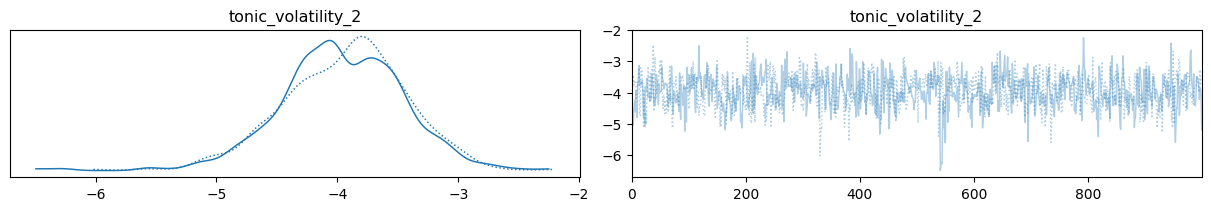

In [13]:
az.plot_trace(sigmoid_hgf_idata, var_names=["tonic_volatility_2"]);
az.summary(sigmoid_hgf_idata, var_names=["tonic_volatility_2"])

The results above indicate that given the responses provided by the participant, the most likely values for the parameter $\omega_2$ are between -4.9 and -3.1, with a mean at -3.9 (you can find slightly different values if you sample different actions from the decisions function). We can consider this as an excellent estimate given the sparsity of the data, and the complexity of the model.

## Glossary

```{glossary}

Perceptual model
    The perceptual model of a Hierarchical Gaussian Filter traditionally refers to the branch receiving observations $u$ about states of the world and that performs the updating of beliefs about these states. By generalisation, the perceptual model is any probabilistic network that can be created in [pyhgf](https://github.com/ComputationalPsychiatry/pyhgf), receiving an arbitrary number of inputs. An HGF that only consists of a perceptual model will act as a Bayesian filter.

Response model
    The response model of a Hierarchical Gaussian filter refers to the branch that uses the beliefs about the state of the world to generate actions using the {term}`Decision rule`. This branch is also sometimes referred to as the **decision model** or the **observation model**, depending on the fields. Critically, this part of the model can return the surprise ($-\log[Pr(x)]$) associated with the observations (here, the observations include the inputs $u$ of the probabilistic network, but will also include the responses of the participant $y$ if there are some).

Decision rule
    The decision rule is a function stating how the agent selects among all possible actions, given the state of the beliefs in the perceptual model, and optionally additional parameters. Programmatically, this is a Python function taking a perceptual model as input (i.e. an instance of the HGF class), and returning a sequence of actions. This can be used for simulation. The decision rule should be clearly defined in order to write the {term}`Response function`.

Response function
    The response function is a term that we use specifically for this package ([pyhgf](https://github.com/ComputationalPsychiatry/pyhgf)). It refers to the Python function that, using a given HGF model and optional parameter, returns the surprise associated with the observed actions.

```

## System configuration

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Sun May 11 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 9.2.0

pyhgf : 0.2.6
jax   : 0.4.31
jaxlib: 0.4.31

sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
arviz     : 0.21.0
numpy     : 2.2.5
matplotlib: 3.10.1
jax       : 0.4.31
pyhgf     : 0.2.6
IPython   : 9.2.0
pymc      : 5.22.0

Watermark: 2.5.0

